# Homework 4 

## Group 9 : 

Giulia Scialanga, Theodoros Sofianos, Matteo Zmyslowski

# _Does basic house information reflect house's description?_

### Goal 
Implement two clustering and compare the results. We need to create two datasets and each of them will be filled by data that we scraped.

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from nltk import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import inflect
import math
import numpy as np 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time

# 1) Scraping 

We select 10.103 announcements from https://www.immobiliare.it . To do this we implement an algorithm that, for each page of the website, opens each announcement and extracts the informations we need. At first we make a get request on the page that contains all the announcements. If the request is success (it has code 200) we create a BeautifulSoup object to parse html page, otherwise we go on with the next page. To access each announcement in that page, we use a find_all operation in order to retrieve all the paragraphs that should contain the links of the announcements. In every paragraph we search < a > tag and we take the link. If the link doesn't appear like 'https://www.immobiliare.it/....' we go on to the next announcement. At this point we make another get request on the announcement's link and if the request is success (it has code 200) we start to parse the announcement. We want to extract from its html page the following informations: prezzo, locali, superficie, bagni, piano and descrizione. Analyzing the html code we notice that:

- some announcements haven't all the informations so we decide to drop them, to do this we extract the content of the < ul > tag with the attribute "class = list-inline list-piped features__list" and then we search the < li > tag which contain the informations. If the we retrieve less then 4 informations or more than 5 informations we drop the announcement;

- some announcements refers to multiple appartaments so we decide to drop them, to do this we extract the content of the < li > tag with the attribute "class = features__price--double". If it is not empty, we drop it;

- some announcements present instead of the price the 'SU' or 'Prezzo su richiesta' value, so we decide to drop them.

To extract the price we parse the content of the < li > tag with the attribute "class = features__price" and we remove the '.' and '€' characters. To extract the description we parse the content of the < div > tag with the attribute "class = description-text".

In order to clean all data we do the following considerations: 

- if the announcement has '5+' "locali" we decide to replace it with '6' value because it has at least 6 locali;

- if the announcement has '3+' "bagni" we decide to replace it with '4' value because it has at least 4 bagni;

- if the announcement is on the top floor ('A') we decide to replace it with '50' value. We choose this high value because we don't know the real floor of the apartment;

- if the announcement is on the ground floor ('T') we decide to replace it with '0' value;

- if the announcement is is on the basement floor ('S') we decide to replace it with '-1' value;

- if the announcement is is on the mezzanine floor ('R') we decide to replace it with '0.5' value.

In the end we append the informations (prezzo, locali, superficie, bagni, piano e descrizione) in two different lists, the first one that contains all the descriptions named "descriptions" and the second one that contains prezzo, locali, superficie and piano named "informations".

We repeat all the previous steps until we retrieve at least 10k announcements.

In [19]:
%%time
print("Inizio elaborazione", time.strftime("%H:%M:%S"))
descriptions = []
informations = []
i = 1
num_req = 0
while len(informations) < 10100:
    if num_req == 100:
        time.sleep(5)
        num_req = 0
    link = requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i))
    if link.status_code != 200:
        print("Richiesta GET pagina fallita")
        continue
    num_req += 1
    soup = BeautifulSoup(link.content, 'lxml')
    features = soup.find_all('p', attrs={'class': 'titolo text-primary'})
    for elem in features:
        row = []
        link = elem.find('a').get('href')
        if 'https://www.immobiliare.it' in link:
            if num_req == 100:
                time.sleep(5)
                num_req = 0
            annuncio = requests.get(link)
            if annuncio.status_code != 200:
                print("Richiesta GET annuncio fallita")
                continue
            num_req += 1
            soup = BeautifulSoup(annuncio.content, 'lxml')
            if (soup.find('li', attrs={'class': 'features__price--double'}) != None): 
                continue
            info = soup.find('ul', attrs = {'class':'list-inline list-piped features__list'})
            if info == None:
                continue
            info = info.find_all('li')
            if len(info) < 4 or len(info) > 5: 
                continue
            if len(info) == 4 and info[-1].get_text() == 'immobilegarantito':
                continue
            price = soup.find('li', attrs={'class': 'features__price'})
            des = soup.find('div', attrs={'class': 'description-text'})
            if des == None or price == None:
                continue
            price = price.get_text().strip()
            price = price.replace('.','').replace('€', '').strip()
            des = des.get_text().strip()
            if price == 'SU' or 'da' in price or 'Prezzo su richiesta' == price:
                continue
            if 'Prezzo diminuito di' in price: 
                price = price[:price.find(' ')]
            row.append(price)
            for tag in info: 
                text = tag.get_text().strip().split()
                if text[0] != 'immobilegarantito': 
                    row.append(text[0])
            row[1] = row[1].replace('5+','6').strip()
            row[3] = row[3].replace('3+','4').strip()
            row[4] = row[4].replace('A','50').replace('R','0.5').replace('T','0').replace('S','-1').strip()
            informations.append(row) 
            descriptions.append(des)
            if len(informations)%1000 == 0:
                print("Elaborati", len(informations), "annunci", time.strftime("%H:%M:%S"))
    i += 1
print("Fine elaborazione", time.strftime("%H:%M:%S"))

Inizio elaborazione 02:48:58
Elaborati 1000 annunci 03:30:17
Elaborati 2000 annunci 04:08:00
Elaborati 3000 annunci 04:45:52
Elaborati 4000 annunci 05:27:17
Elaborati 5000 annunci 06:08:09
Elaborati 6000 annunci 06:50:33
Elaborati 7000 annunci 07:28:19
Elaborati 8000 annunci 08:12:22
Elaborati 9000 annunci 08:51:04
Elaborati 10000 annunci 09:37:46
Fine elaborazione 09:41:57
Wall time: 6h 52min 58s


We create a pandas DataFrame by the list named "informations". 

In [69]:
data_informations = pd.DataFrame(informations)

In [70]:
data_informations = data_informations.rename(columns={0 : "Prezzo", 1 : "Locali", 2 :"Superficie", 3 :"Bagni", 4 :"Piano"})

We notice that the column 'Piano' contains some values '11+' and we decide to replace this value with '12' because this floor it is at least on 12th floor. 

In [71]:
data_informations['Piano'] = data_informations['Piano'].replace('11+', '12')

We decide to save our DataFrame, that contains informations, into csv file because the time execution of scraping is too long to run every time. We work with this csv file.

In [72]:
data_informations.to_csv(path_or_buf="C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/informations.csv", index=False)

In [12]:
data_informations = pd.read_csv("C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/informations.csv")


We show a sample of this dataset.

In [13]:
data_informations.head(10)

,Prezzo,Locali,Superficie,Bagni,Piano
0,225000,2,50.0,1,1.0
1,669000,5,86.0,2,4.0
2,500000,3,89.0,2,3.0
3,400000,3,60.0,1,3.0
4,574000,4,89.0,2,5.0
5,300000,2,46.0,1,4.0
6,425000,3,72.0,2,4.0
7,257000,3,61.0,1,1.0
8,657000,5,87.0,2,5.0
9,325000,2,60.0,1,3.0


# Pre-processing descriptions. 
## Lower case
The first pre-processing step is to transform our descriptions into lower case. 

## Tokenization
Tokenization refers to dividing the text into a sequence of words or sentences.

## Removing Punctuation and Stop Words
The next step is to remove punctuation and stopwords, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the data.

## Stemming
Stemming refers to the removal of suffices by a simple rule-based approach. For this purpose, it will be used SnowballStemmer from the NLTK library.


In [4]:
class Preprocessing(): 
    def __init__(self,language):
        self.tokenizer = None
        self.stopwords = None
        self.stemmer = None
        self.number_to_words = None
        self.language = language
    
    def setupNltk(self):
        #Lazy initialization of objects needed to preprocess strings
        if self.tokenizer == None:
            self.tokenizer = RegexpTokenizer(r'\w+')
        if self.stopwords == None:
            self.stopwords = set(stopwords.words(self.language))
        if self.stemmer == None:
            self.stemmer = SnowballStemmer(self.language)
        if self.number_to_words == None:
            self.number_to_words = inflect.engine()
    
    def nltkProcess(self, string):
        #Transform all words to lowercase
        string = string.lower()
        #Setup nltk objects to perform preprocessing
        self.setupNltk()
        #Tokenize the string removing puntuactions
        tokens = self.tokenizer.tokenize(string)
        #Create new sentence
        new_sentence = []
        #Scroll through each word and stemming it
        for word in tokens:
            word = self.stemmer.stem(word)
            #exclude the word if it is a stopword
            if not word in self.stopwords:
                #if the word has length greater than one, it has sufficient information
                #value to be added
                if len(word) > 1:
                    new_sentence.append(word)
                #if the word length is equal to one and it is numeric
                #then the string representation of the number is added
                elif word.isnumeric():
                    new_sentence.append(self.number_to_words.number_to_words(word))           
        # return a list of words
        return new_sentence
        
        
        

In [5]:
# We create an object called preprocessing 
preprocessing = Preprocessing('italian')

In [7]:
# Save in descriptions all the processed words of each announcment. 
for i in range(len(descriptions)): 
    descriptions[i] = preprocessing.nltkProcess(descriptions[i])
    

In [31]:
# We create a vocabulary where for all words in the announcements is associated an id. 
vocabulary = {}
i = 0 
for ann in descriptions: 
    for word in ann:
        if word not in vocabulary: 
            vocabulary[word] = i
            i += 1
        

# Compute the TF - IDF

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency: 

\begin{equation*}
tf-idf(t,d) = tf(t,d) * idf(t)
\end{equation*}


# Compute the TF

In [33]:
# Compute the term frequency of each words in each documents. 
tf = {}
for i in range(len(descriptions)): 
    set_descriptions = set(descriptions[i])
    for j in set_descriptions: 
        if j not in tf: 
            tf[j] = [(i , descriptions[i].count(j))]
        else: 
            tf[j].append((i,descriptions[i].count(j)))
          

# Compute the IDF 

The idf component is computed as: 

\begin{equation*}
idf(t) = log\frac{1 + n{_d}}{1 + df(d,t)} + 1
\end{equation*}

where *nd*  is the total number of documents, and *df(d,t)* is the number of documents that contain term . The resulting tf-idf vectors are then normalized by the Euclidean norm.

In [35]:
n_ads= len(descriptions)
idf = {}
for k in tf: 
    idf[k] = math.log10(n_ads/len(tf[k]))+1



# Compute the TF-IDF

In [37]:
tf_idf = {}
for k in tf:
    for i in tf[k]:
        if k not in tf_idf:
            tf_idf[k] = [(i[0], i[1] * idf[k])]
        else: 
            tf_idf[k].append((i[0], i[1] * idf[k]))

    

# Execute the Normalization

\begin{equation*}
v{_norm} = \frac{v}{||v||{_2}} = \frac{v}{\sqrt{v^2{_1} + v^2{_2} + ... + v^2{_n}}
\end{equation*}

In [39]:
# We create a dictionary named ads that has for key the announcements and for values the tf-idf for each word of the announcement. 
ads = {}
norm_tfidf = {}
for k in tf_idf: 
    for j in tf_idf[k]: 
        if j[0] not in ads: 
            ads[j[0]] = j[1]**2
        else: 
            ads[j[0]] += j[1]**2
for word in tf_idf:
    for j in tf_idf[word]: 
        if word not in norm_tfidf: 
            norm_tfidf[word] = [(j[0], j[1]/math.sqrt(ads[j[0]]))]
        else: 
            norm_tfidf[word].append((j[0], j[1]/math.sqrt(ads[j[0]])))              

In [41]:
n_ann = len(descriptions)

10103


In [42]:
# We create an empty matrix in which there are as columns all words in the announcements without duplicates and as rows the announcements. 
m = []
for i in range(n_ann): 
    m.append(np.zeros(len(vocabulary)))

In [43]:
# We insert tf-idf values inside the matrix and to do this we use the id associated to the words in the vocabulary (as a id of columns 
# in m) and the id of announcements (as id of rows in m).
for k in norm_tfidf: 
    for elem in norm_tfidf[k]: 
        m[elem[0]][vocabulary[k]] = elem[1]

We create a pandas DataFrame named data_desc which contains all the tf-idf value of the words found inside the descriptions of the announcements. Each row represents an announcment and each columns represents a word.

In [44]:
data_desc = pd.DataFrame(m, columns = list(vocabulary.keys()))

We decide to save our DataFrame, that contains descriptions, into csv file because the time execution of scraping is too long to run every time. We work with this csv file.

In [46]:
data_desc.to_csv(path_or_buf="C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/descriptions.csv", index=False)

In [9]:
data_desc = pd.read_csv("C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/descriptions.csv")

We show a sample of this dataset.

In [10]:
data_desc.head(10)

,papill,eur,eleg,compless,residenzial,rifinitissim,bilocal,compost,soggiorn,angol,...,corrod,morosin,coppol,musitan,puster,vitaliz,consoli275,caratteristic,affoll,1586
0,0.092966,0.049141,0.055354,0.055478,0.051298,0.083891,0.059027,0.032066,0.039711,0.047012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072976,0.045188,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073299,0.045388,0.053732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072681,0.045005,0.053279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073615,0.045584,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068228,0.074129,0.045902,0.054340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073864,0.045737,0.054146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.114517,0.035296,0.000000,0.000000,0.022063,0.027324,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072510,0.044899,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069211,0.075196,0.046563,0.055123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering 

This step consists in clustering the house announcements using *K-means++* and choose the optimal number of clusters using the *Elbow-Method*. 

The performance of the original k-means depends heavily on the initialization of centroids. Poor initialization of centroids will produce bad clustering. 

*K-means++* is designed to improve the centroid initialization for k-means. The basic idea is that the initial centroid should be far away from each other. The algorithm starts by randomly choosing a centroid c0 from all data points. For centroid ci, the probability of a data point *x* been chosen as a centroid is proportional to the squares of the distance of *x* to its nearest centroid.

In this way, k-means++ always tries to select centroids that are far away from the existing centroids, which leads to significant improvement over k-means with a bit sacrifice on the run time.

To choose the optimal numer of clusters we use the Elbow-Method: we should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. The number of clusters is chosen at this point, hence the "elbow criterion". We choose the optimal number of cluster where we see the "elbow" in our plot. 

In [14]:
info_means = []
for k in range(1,20):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_informations)
    info_means.append(kmeans.inertia_)

We observe that in our plot the "elbow" highlights as 4 the optimal number of cluster. 

C:\Users\giuli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


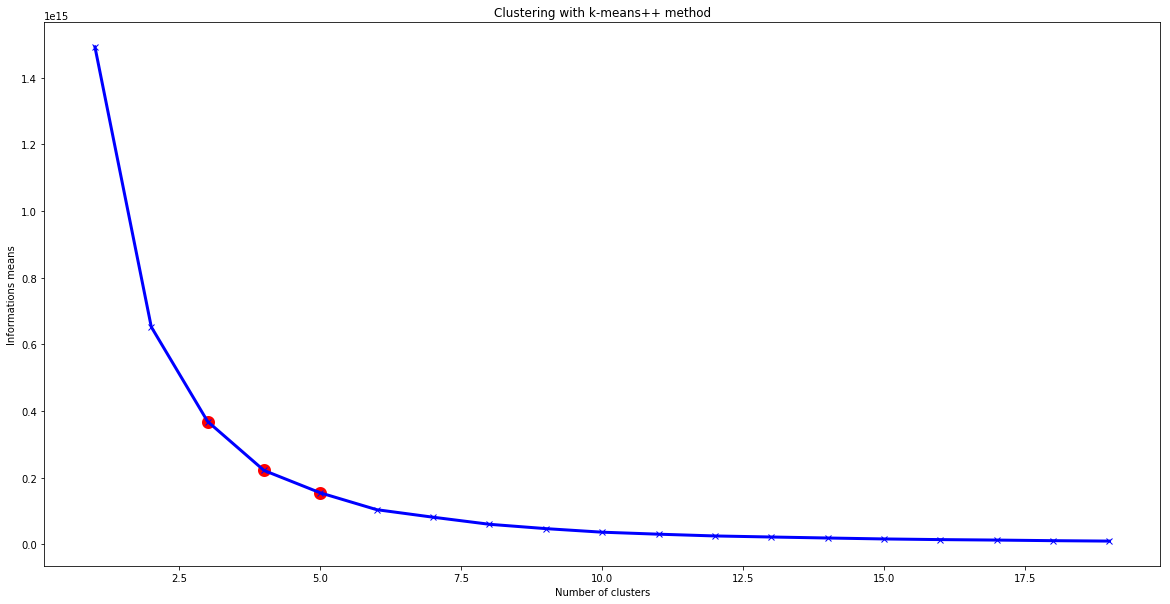

In [18]:
x = range(1,20)
y = info_means
bold = slice(2, 5)
fig = plt.figure(figsize=(20,10))
plt.plot(range(1,20), info_means, "bx-", linewidth = 3.0)
ax = fig.add_subplot(1,1,1)
ax.scatter(x[bold], y[bold], edgecolors='r', linewidths=7)
plt.xlabel('Number of clusters')
plt.ylabel('Informations means')
plt.title('Clustering with k-means++ method')
plt.show()

Using the Elbow method we can observe that the optimal number of clusters is 4. 

In [19]:
#We compute the K-means ++ for 4 clusters (that is the number of optimal cluster)
for k in range(1,5):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_informations)

In [20]:
labels = kmeans.labels_

We create a dictionary named "informations_labels" that has as keys the number of optimal cluster and as values a list of indices of announcements refears to informations.  

In [21]:
informations_labels = {}
for i in range(len(labels)): 
    if labels[i] not in informations_labels: 
        informations_labels[labels[i]] = [i]
    else: 
        informations_labels[labels[i]].append(i)

We perform the previous analysis for the matrix of decriptions. 

In [107]:
%%time
des_means = []
for k in range(1,20):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_desc)
    des_means.append(kmeans.inertia_)

Wall time: 2h 56min 42s


We save the list named des_means inside a txt file. 

In [418]:
with open('des_means.txt', 'w') as f:
    for item in des_means:
        f.write("%s\n" % item)

In [27]:
des_means = []
with open('des_means.txt', 'r') as f:
    for value in f:
        des_means.append(float(value.strip()))

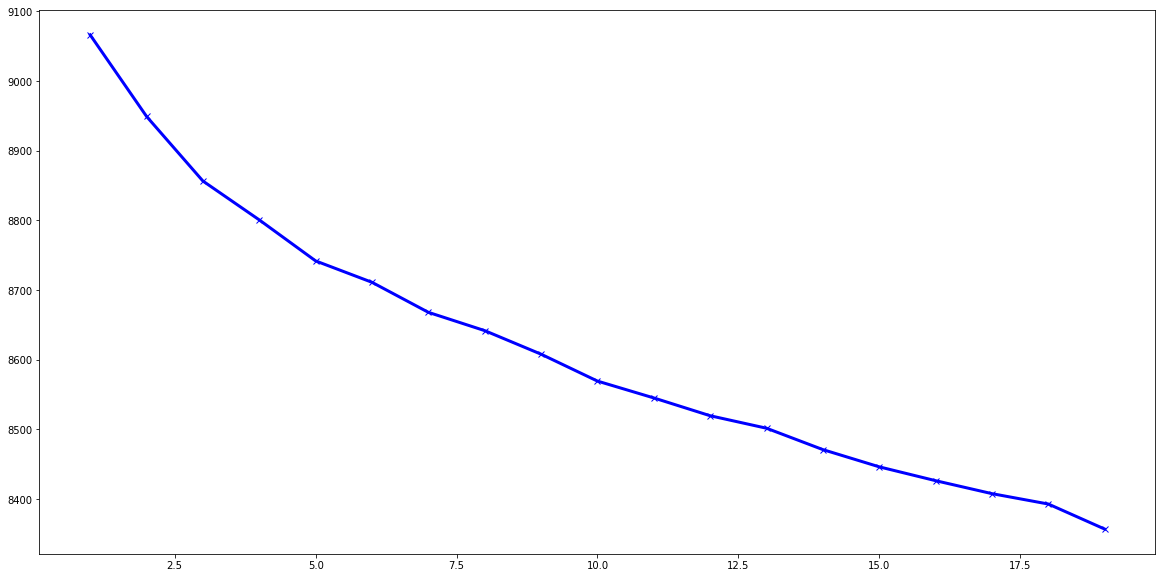

In [29]:
fig = plt.figure(figsize=(20,10))
plt.plot(range(1,20), des_means, "bx-", linewidth = 3.0)
plt.show()

We notice the optimal number of clusters it's to high to be performed. The previous plot shows a sample with at most 20 clusters. For this reason we decide to choose 4 optimal number of clusters in order to compare clusters with Jaccard-similarity. 

In [ ]:
for k in range(1,5):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_desc)

In [111]:
labels = kmeans.labels_

We create a dictionary named "des_labels" that has as keys the number of optimal cluster and as values a list of indiced of announcements refears to descriptions. 

In [113]:
des_labels = {}
for i in range(len(labels)): 
    if labels[i] not in des_labels: 
        des_labels[labels[i]] = [i]
    else: 
        des_labels[labels[i]].append(i)

# Find similar clusters

## To check this, use the Jaccard-Similarity to measure the similarity betweeen the two outputs (information clusters vs description clusters). Return the 3-most similar couples of clusters.

The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient (originally coined coefficient de communauté by Paul Jaccard), is a statistic used for comparing the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:


\begin{equation*}
J(A,B) = \frac{|A \cap B|}{|A \cup B|}
\end{equation*}

with 


\begin{equation*}
0 <= J(A,B) <= 1
\end{equation*}

The goal of our analysis is to find the 3-most similar couples of clusters (highest Jaccard-similarity values).  

In [273]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(set(list2)))
    union = len(set(list1).union(set(list2)))
    return float(intersection / union)

In [383]:
# Jaccard distance 
jaccard = []
for i in informations_labels: 
    for j in des_labels: 
        jaccard.append(jaccard_similarity(informations_labels[i], des_labels[j]))
        

In [423]:
for i in range(len(jaccard)):
    print("("+str(i//4)+", "+str(i%4)+") =", jaccard[i])

(0, 0) = 0.48201715090234226
(0, 1) = 0.21358787198203258
(0, 2) = 0.16320152194591656
(0, 3) = 0.017943605810310452
(1, 0) = 0.10253600500939261
(1, 1) = 0.3018476230018684
(1, 2) = 0.08727370980815996
(1, 3) = 0.010054137664346482
(2, 0) = 0.028098844161020327
(2, 1) = 0.09949874686716792
(2, 2) = 0.017110266159695818
(2, 3) = 0.0
(3, 0) = 0.004092181779022184
(3, 1) = 0.014606155451225874
(3, 2) = 0.001218769043266301
(3, 3) = 0.0


In [385]:
jac = jaccard.copy()
jac.sort(reverse = True)

In [387]:
max_j = []
for i in range(3):
    idx = jaccard.index(jac[i])
    max_j.append((idx//4, idx%4))


In [388]:
#We observe that the 3-most similar couples of clusters are:
max_j

[(0, 0), (1, 1), (0, 1)]

In [395]:
# In this part of code we obtain all the indeces that refears to the descriptions's announcements 
cloud = []
for i in max_j: 
    cloud.append(list(set(informations_labels[i[0]]).intersection(set(des_labels[i[1]]))))
    
    

In [396]:
cloud

[[1,
  2,
  8195,
  4,
  6,
  8,
  8201,
  11,
  8204,
  4115,
  22,
  23,
  25,
  8217,
  34,
  35,
  2083,
  6180,
  6184,
  8235,
  2091,
  45,
  2095,
  48,
  6194,
  8243,
  53,
  6198,
  4156,
  61,
  4157,
  4159,
  2113,
  8263,
  6215,
  4173,
  2128,
  6226,
  85,
  86,
  6230,
  8282,
  91,
  97,
  4193,
  99,
  100,
  101,
  6244,
  104,
  6248,
  6249,
  4205,
  4209,
  2162,
  8309,
  6263,
  120,
  122,
  123,
  4220,
  4222,
  129,
  8322,
  6275,
  6277,
  6282,
  139,
  6283,
  6286,
  8335,
  144,
  145,
  6288,
  8343,
  152,
  8345,
  154,
  2201,
  2204,
  4247,
  8353,
  2210,
  163,
  4263,
  169,
  6320,
  181,
  183,
  2238,
  191,
  6340,
  202,
  2250,
  207,
  6357,
  6361,
  2267,
  8416,
  4321,
  8423,
  232,
  4328,
  236,
  6380,
  2286,
  2291,
  247,
  2297,
  8443,
  6395,
  253,
  2302,
  258,
  6403,
  6408,
  265,
  6409,
  2317,
  270,
  2318,
  6415,
  273,
  6418,
  4373,
  8474,
  2335,
  4390,
  6441,
  2350,
  2354,
  4420,
  2373,
  4429,
